In [89]:
import pandas as pd 
import numpy as np 
import seaborn as sns

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [90]:
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [91]:
data = data.rename(columns={"#Passengers": "Passengers"}, inplace=False)
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [92]:
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Plot time series data

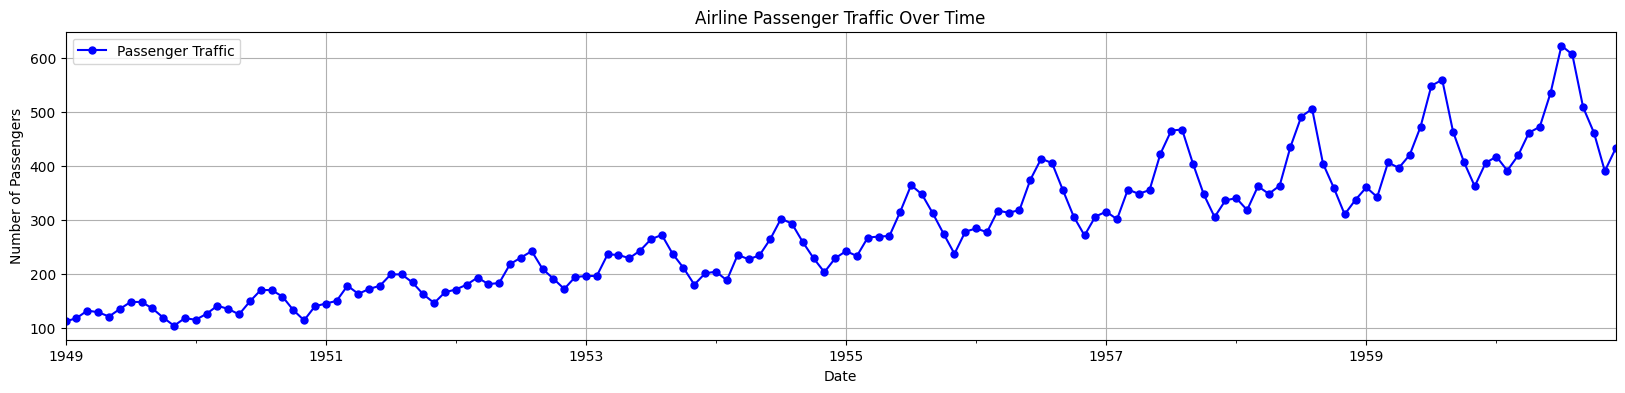

In [93]:
data.plot(y='Passengers', figsize=(20, 4), color='blue', linestyle='-', marker='o', markersize=5, label='Passenger Traffic')
plt.grid(True)
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Over Time')
plt.xlabel('Date')  
plt.ylabel('Number of Passengers')  
plt.show(block=False)

# Missing value treatment

## Mean imputation

In [94]:
data['Passengers_Mean_Imputation'] = data['Passengers'].fillna(data['Passengers'].mean())

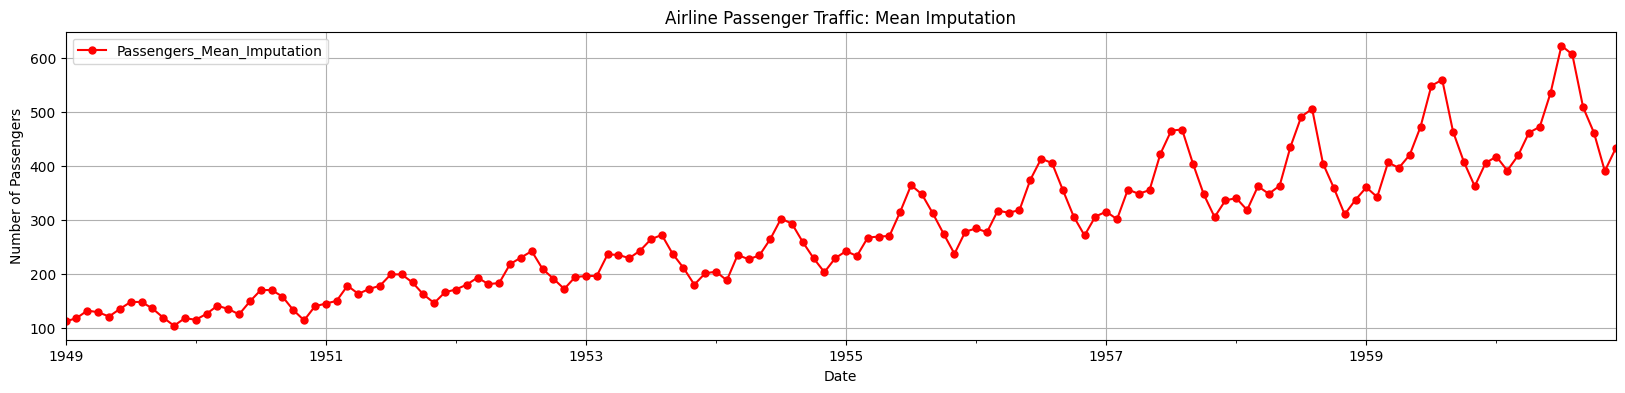

In [95]:
data[['Passengers_Mean_Imputation']].plot(figsize=(20, 4), grid=True, legend=True, color='red', linestyle='-', marker='o', markersize=5)
plt.title('Airline Passenger Traffic: Mean Imputation')
plt.xlabel('Date')  
plt.ylabel('Number of Passengers') 
plt.show(block=False)

## Linear interpolation¶


In [96]:
data['Passengers_Linear_Interpolation'] = data['Passengers'].interpolate(method='linear')

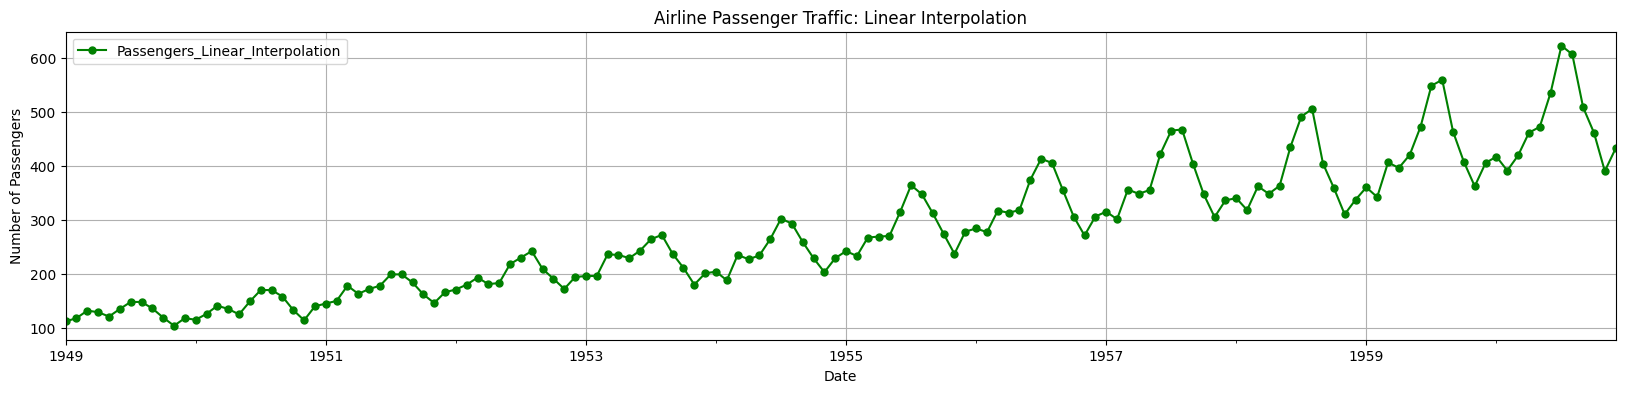

In [97]:
data[['Passengers_Linear_Interpolation']].plot(figsize=(20, 4), grid=True, legend=True, color='green', linestyle='-', marker='o', markersize=5)
plt.title('Airline Passenger Traffic: Linear Interpolation')
plt.xlabel('Date')  
plt.ylabel('Number of Passengers')  
plt.show(block=False)

In [98]:
data.head()

,Passengers,Passengers_Mean_Imputation,Passengers_Linear_Interpolation
Month,,,
1949-01-01,112,112,112
1949-02-01,118,118,118
1949-03-01,132,132,132
1949-04-01,129,129,129
1949-05-01,121,121,121


In [99]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],inplace=True)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Outlier detection

## Box plot and interquartile range

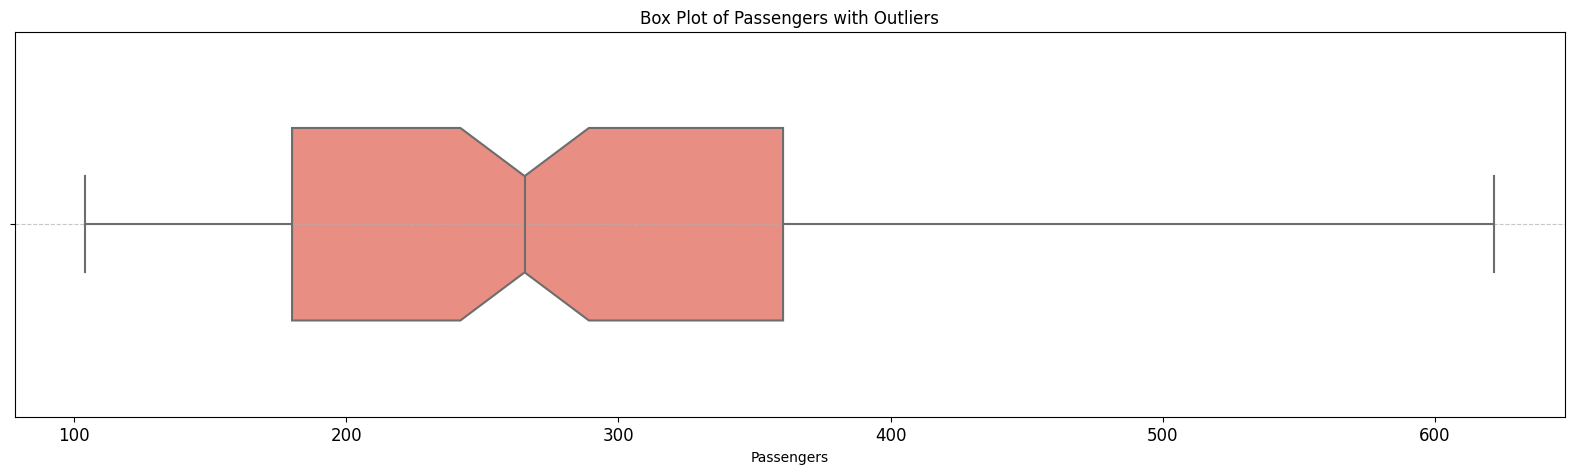

In [100]:
import seaborn as sns
plt.figure(figsize=(20, 5))

sns.boxplot(x=data['Passengers'], color='salmon', width=0.5, notch=True)

plt.title('Box Plot of Passengers with Outliers')
plt.xlabel('Passengers')
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Histogram plot

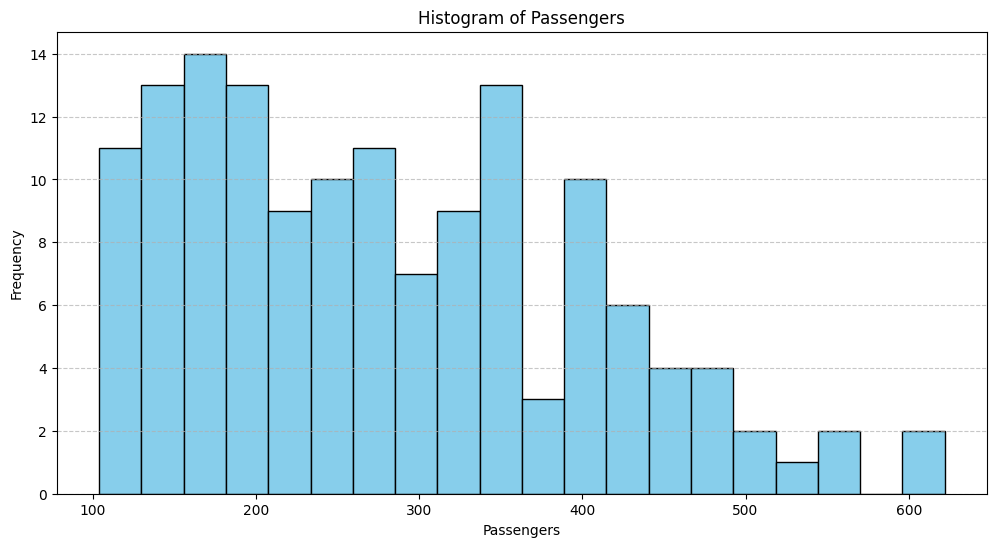

In [101]:
plt.figure(figsize=(12, 6))
plt.hist(data['Passengers'], bins=20, color='skyblue', edgecolor='black')

plt.title('Histogram of Passengers')
plt.xlabel('Passengers')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Time series Decomposition

## Additive seasonal decomposition

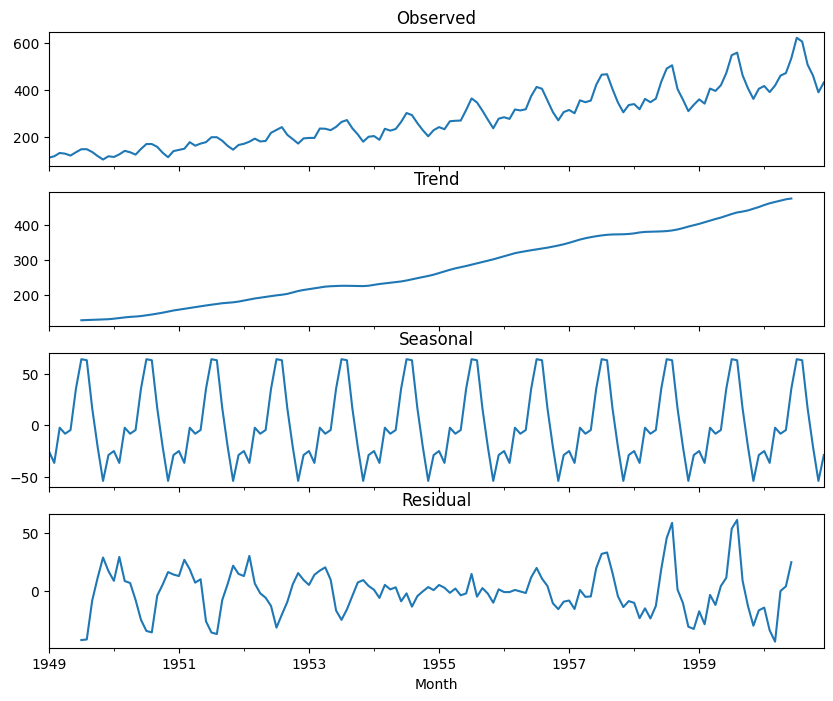

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
result = seasonal_decompose(data['Passengers'], model='additive')  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')

plt.show()

## Multiplicative seasonal decomposition

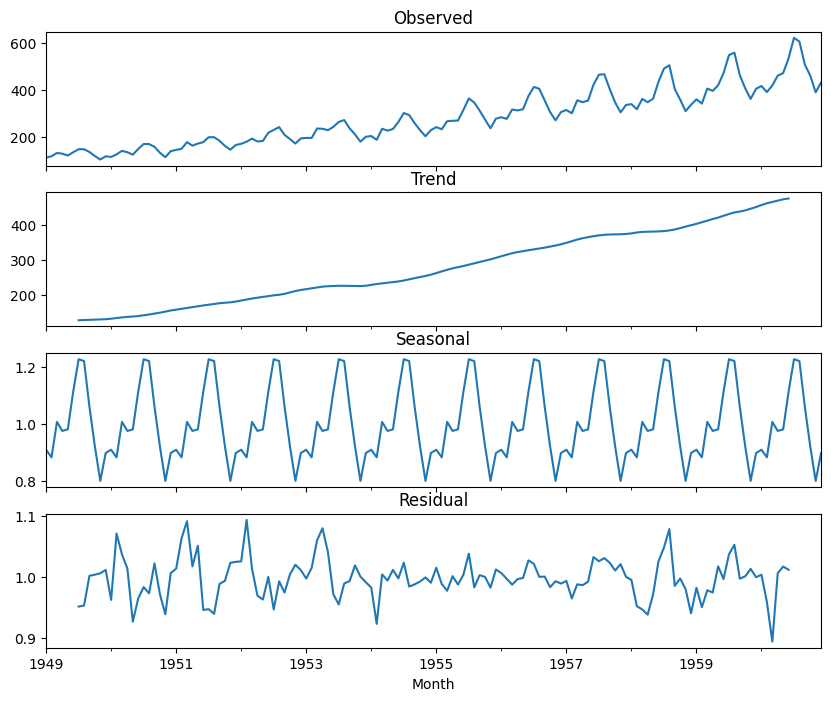

In [103]:
result = seasonal_decompose(data['Passengers'], model='multiplicative') 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')

plt.show()

# Build and evaluate time series forecas

## Split time series data into training and test set

In [104]:
train_len = 120
train = data[:train_len]  # first 120 months as the training set
test = data[train_len:]  # last 24 months as the out-of-time test set

# Exponential smoothing methods

## Simple exponential smoothing

In [105]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [106]:
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

### Plot train, test and forecast

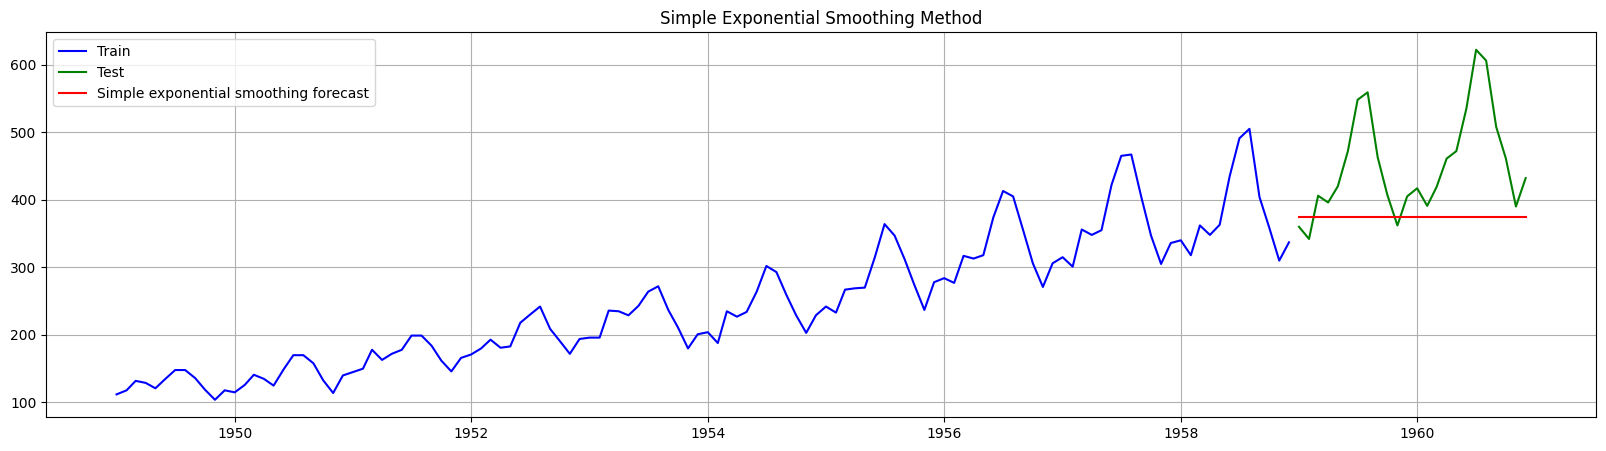

In [107]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Passengers'], label='Train', color='blue')
plt.plot(test['Passengers'], label='Test',color='green')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast',color='red')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [108]:
results = pd.DataFrame(columns=['Method', 'RMSE', 'MAPE'])

In [109]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

In [110]:
tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,107.52,16.43


## Holt's method with trend

In [111]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 118.46666666666661, 'initial_trend': 2.0606060606060677, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/tmp/ipykernel_43/3162401862.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)


In [112]:
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

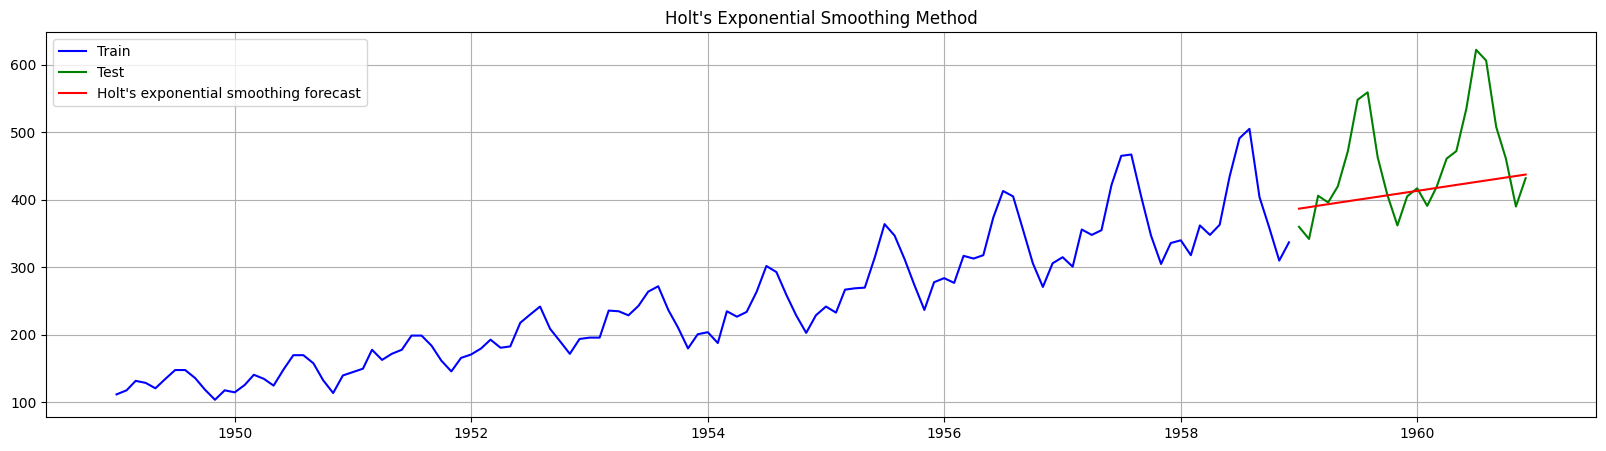

In [113]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot( train['Passengers'], label='Train',color='blue')
plt.plot(test['Passengers'], label='Test',color='green')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast',color='red')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [114]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

In [115]:
tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32


## Holt Winters' additive method with trend and seasonality

In [116]:
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa = test.copy()
forecast_values = model_fit.forecast(len(test))
y_hat_hwa['hw_forecast'] = forecast_values

{'smoothing_level': 0.23678678235712566, 'smoothing_trend': 1.8055668382578714e-09, 'smoothing_seasonal': 0.7632132086415252, 'damping_trend': nan, 'initial_level': 119.1876680939318, 'initial_trend': 2.2768394955266533, 'initial_seasons': array([ -9.42424719,  -3.87104168,   8.69002781,   3.6678027 ,
        -4.94701962,   9.26652064,  21.53444859,  19.2001798 ,
         5.07181472, -13.80997707, -28.51179942, -12.37245268]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


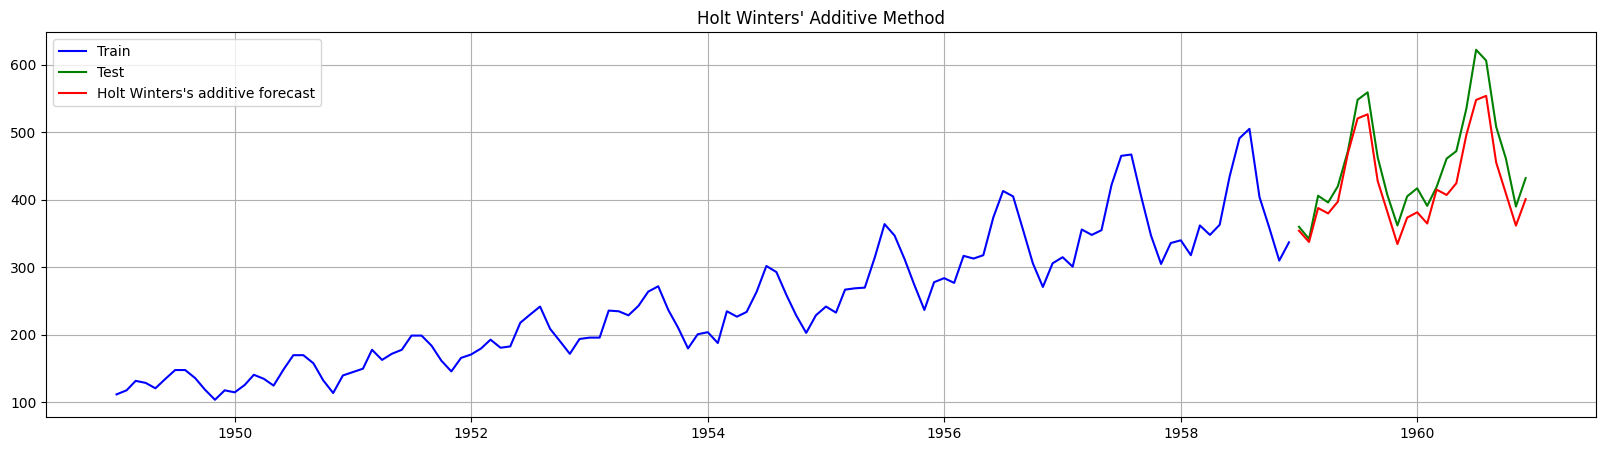

In [117]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot( train['Passengers'], label='Train',color='blue')
plt.plot(test['Passengers'], label='Test',color='green')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast',color='red')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [118]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hw_forecast'])/test['Passengers'])*100,2)

In [119]:
tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64


## Holt Winter's multiplicative method with trend and seasonality


In [120]:
model = ExponentialSmoothing(np.asarray(train['Passengers']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)

{'smoothing_level': 0.364208357460606, 'smoothing_trend': 4.191162581733996e-09, 'smoothing_seasonal': 0.6357916412612594, 'damping_trend': nan, 'initial_level': 110.89386078445895, 'initial_trend': 2.389331198805944, 'initial_seasons': array([0.98867675, 1.03912176, 1.14217091, 1.08689584, 1.00612809,
       1.10442233, 1.20431631, 1.18998306, 1.08561792, 0.94580897,
       0.84005265, 0.96819086]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [121]:
y_hat_hwm = test.copy()
forecast_values = model_fit.forecast(len(test))
y_hat_hwm['hw_forecast'] = forecast_values

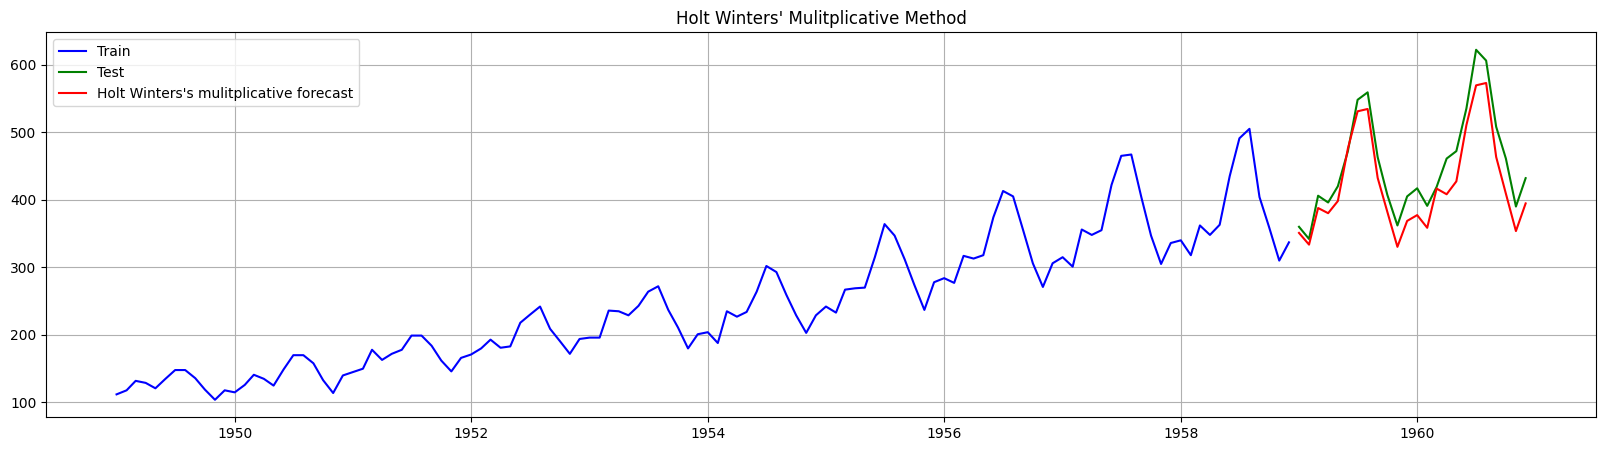

In [122]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot( train['Passengers'], label='Train',color='blue')
plt.plot(test['Passengers'], label='Test',color='green')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast',color='red')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [123]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hw_forecast'])/test['Passengers'])*100,2)

In [124]:
tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,107.52,16.43
0,Holt's exponential smoothing method,80.90,11.32
0,Holt Winters' additive method,35.76,6.64
0,Holt Winters' multiplicative method,32.49,6.39


i recommend to use Holt Winters' multiplicative method for accurate prediction for time series as it has least RMSE among all.